# Potential

Check out the readme in this directory for further explanations

In [1]:
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta
import pytz
tzET = pytz.timezone('US/Eastern')
import math
import numpy as np # grouping symbols in array

# input files
import json
import sys

In [2]:
# returns public and secure key from alpaca and paper trading url
# these should really be stored securely in a different file
def getKeys():
  pub = 'PKJ0P4P4I3IKN3EM29U0'
  sec = 'x3FGUvHqQEGCHHAClL10O3C6Ywo6NGgmbwXtBmwp'
  url = 'https://paper-api.alpaca.markets' # in production remove 'paper-'
  return pub, sec, url

In [3]:
# starts up alpaca account and prints the portfolio cash
def initAlpaca():
  global api

  import alpaca_trade_api as tradeapi
  import websocket

  # START UP ACCOUNT
  public, secret, url = getKeys()
  api = tradeapi.REST(public, secret, url, api_version='v2')
  account = api.get_account()
  assert(account.status == 'ACTIVE')
  print('Account is active !')

In [4]:
def getBarsetForSymbols(symbols, startIso, endIso):
  return api.get_barset(
    symbols, 
    'minute',
    start=startIso,
    end=endIso,
  )

In [5]:
def roundDown(input, dp):
  factor = 10 ** dp
  return math.floor(input * factor)/factor

def roundUp(input, dp):
  factor = 10 ** dp
  return math.ceil(input * factor)/factor

In [6]:
def printStockDictionary(d):
  listEarning = sorted(d.items(), key=lambda item: item[1])
  listEarning.reverse()
  
  print('{')
  listSize = len(listEarning)
  for i, (key, value) in enumerate(listEarning):
    if i < 20 or i >= listSize - 5:
      print('  ', str.ljust(key, 4),':', roundUp(value,2))
    elif i == 20:
      print('    ...')
  print('}')

In [7]:
def getPotentialEarnings(bars):
  amt = 1
  for bar in bars:
    if bar.c > bar.o:
      amt *= (bar.c / bar.o)
  return amt

In [8]:
# unused but may be useful when writing all results to file
# def writeToFile():
#   with open(sys.path[0] + 'stock_race.json', 'w') as outfile:
#     json.dump(dict(listEarning), outfile)

In [9]:
# does approx 100 symbols in 30 sec, try 6000 symbols... 1800sec = 30min
def compareStocks(symbols, startIso, endIso):
  
  # to reduce the number of api calls, get the barset for 200 stocks at a time
  startIndex = 0
  n = len(symbols)
  
  symEarnDict = {}
  
  while startIndex < n:
    # get end index for max 200 stocks
    endIndex = startIndex + 199
    if endIndex > n - 1:
      endIndex = n - 1
    # form array of max 200 stocks
    symbolsMax200 = np.empty(endIndex - startIndex + 1, object)
    for i in range(startIndex, endIndex + 1):
      symbolsMax200[i - startIndex] = symbols[i]
    # api call
    barset = getBarsetForSymbols(symbolsMax200, startIso, endIso)
    # for each item in barset, get earnings
    for symbolKey, bars in barset.items():
      symEarnDict[symbolKey] = getPotentialEarnings(bars)
    startIndex += 200
  
  # print out pretty results  
  printStockDictionary(symEarnDict)

These 21 stocks were picked knowing the first 18 are the best stocks in June. FB and google are common stocks for comparison and ASGI is a stock that doesn't go up so has value 1. That makes 21 stocks

In [10]:
# 21 stocks for 1 month takes ~5 seconds
initAlpaca()

symbols = ['HTZ', 'CPE', 'VAL', 'RIG','IVR','QEP','WLL','NCLH','KOS','AR','MFA',\
  'M','NIO','GPS','CCL','SAVE','SWN','OXY','FB','GOOG','ASGI']

compareStocks(
  symbols,
  datetime(2020, 6, 1, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 6, 30, 16, 0, 0, tzinfo=tzET).isoformat()
)

Account is active !
{
   HTZ  : 4855919121.21
   CPE  : 68844.91
   VAL  : 56314.14
   RIG  : 33101.71
   IVR  : 14856.34
   QEP  : 14746.91
   WLL  : 14000.56
   NCLH : 12555.07
   KOS  : 5903.76
   AR   : 5371.65
   MFA  : 3835.25
   M    : 2182.95
   NIO  : 2091.46
   GPS  : 1897.33
   CCL  : 1772.11
   SAVE : 1275.51
   SWN  : 964.21
   OXY  : 884.95
   FB   : 10.14
   GOOG : 1.53
   ASGI : 1.0
}


Takes all 3123 NYSE stocks (symbols from file nyse_symbols.json) and compares them. HTZ could have made 4,855,919,121.21 ~= $ 4.8 Billion!

In [11]:
# 3123 stocks for 1 month takes ~ 2min 12seconds
initAlpaca()

symbolFileName = sys.path[0] + '/nyse_symbols.json'
with open(symbolFileName) as f:
  data = json.load(f)
symbols = data['symbols']
print('number of stocks =', len(symbols))
  
compareStocks(
  symbols,
  datetime(2020, 6, 1, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 6, 30, 16, 0, 0, tzinfo=tzET).isoformat()
)

Account is active !
number of stocks = 3123
{
   HTZ  : 4855919121.21
   CPE  : 68844.91
   VAL  : 56314.14
   RIG  : 33639.63
   IVR  : 14856.34
   QEP  : 14746.91
   WLL  : 14000.56
   NCLH : 12555.07
   KOS  : 5903.76
   AR   : 5371.65
   MFA  : 3835.25
   M    : 2182.95
   NIO  : 2091.46
   GPS  : 1897.33
   CCL  : 1772.11
   SAVE : 1277.71
   SWN  : 962.22
   OXY  : 884.95
   COTY : 763.98
   RRC  : 684.37
    ...
   AEL^B : 1.0
   AEL^A : 1.0
   ABR^C : 1.0
   ABR^B : 1.0
   ABR^A : 1.0
}


By graphing the top 20 potential stocks from YTD we can see that the recession had a high impact on all stocks with many even going bankrupt. HTZ filed for chapter 11. Since the stock price dropped but assuming the volitility remained high, the gain percentage was higher especially with the spike in early June*. That is why these high risk stocks had the most potential. 

*could be because “The United States printed more money in June than in the first two centuries after its founding,” https://cointelegraph.com/news/us-printed-more-money-in-one-month-than-in-two-centuries

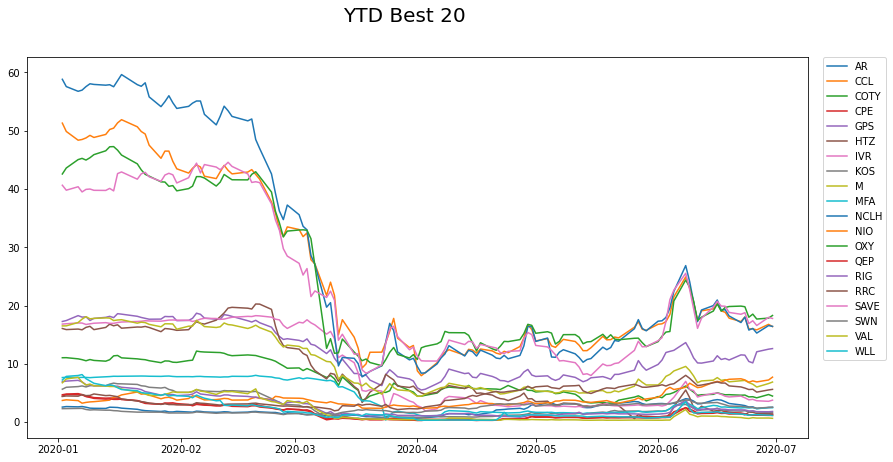

In [12]:
# graphing the top 20 stocks ytd

symbols20 = ['HTZ', 'CPE', 'VAL', 'RIG','IVR','QEP','WLL','NCLH','KOS','AR','MFA',\
  'M','NIO','GPS','CCL','SAVE','SWN','OXY', 'COTY', 'RRC']

import matplotlib.pyplot as plt
plt.rcParams['timezone'] = 'US/Eastern'
import matplotlib.dates as mdates # for formatting dates in graph
import pandas as pd

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('YTD Best 20', fontsize=20)


barset = api.get_barset(
  symbols20, 
  'day',
  start = datetime(2020, 1,  1,  9, 30, 0, tzinfo=tzET).isoformat(),
  end   = datetime(2020, 6, 30, 16,  0, 0, tzinfo=tzET).isoformat(),
)
# first entries bars
for symbolKey, bars in barset.items():
  times = []
  closes = []
  for b in bars:
    times.append(b.t.astimezone(tzET))
    closes.append(b.c)
  ax.plot(times, closes, label=symbolKey)
ax.legend(loc='upper right', bbox_to_anchor=(0,1,1.1,0), borderaxespad=0, ncol=1)
  
plt.show()